# Skintelligence
## Image feature extraction and Multi-label classification

### Importing packages and data

In [1]:
import os
import re
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

import torch.nn as nn
from PIL import Image
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, datasets, transforms

Set project and image directory paths

In [2]:
proj_dir = os.path.join(os.getcwd(), os.pardir)
img_dir = os.path.join(proj_dir, 'Data', 'Final', 'Images')
train_img_file = os.path.join(proj_dir, 'Data', 'Final', 'img_train.csv')
val_img_file = os.path.join(proj_dir, 'Data', 'Final', 'img_val.csv')
test_img_file = os.path.join(proj_dir, 'Data', 'Final', 'img_test.csv')

Read the VQA dataset to fetch medical annotations

In [3]:
df_train = pd.read_csv(train_img_file)
df_val = pd.read_csv(val_img_file)
df_test = pd.read_csv(test_img_file)

In [4]:
df_train.columns

Index(['skincap_file_path', 'disease', 'Vesicle', 'Papule', 'Macule', 'Plaque',
       'Abscess', 'Pustule', 'Bulla', 'Patch', 'Nodule', 'Ulcer', 'Crust',
       'Erosion', 'Excoriation', 'Atrophy', 'Exudate', 'Purpura/Petechiae',
       'Fissure', 'Induration', 'Xerosis', 'Telangiectasia', 'Scale', 'Scar',
       'Friable', 'Sclerosis', 'Pedunculated', 'Exophytic/Fungating',
       'Warty/Papillomatous', 'Dome-shaped', 'Flat topped',
       'Brown(Hyperpigmentation)', 'Translucent', 'White(Hypopigmentation)',
       'Purple', 'Yellow', 'Black', 'Erythema', 'Comedo', 'Lichenification',
       'Blue', 'Umbilicated', 'Poikiloderma', 'Salmon', 'Wheal', 'Acuminate',
       'Burrow', 'Gray', 'Pigmented', 'Cyst'],
      dtype='object')

### Data Preprocessing

In [5]:
# For initial sampling
#df_med_annot = df_med_annot.drop_duplicates()
#df_sample = df_med_annot.groupby('disease').head(3)
#df_med_annot = df_med_annot.drop(['disease'], axis=1).reset_index(drop=True)

In [6]:
# Column storing image name
img_name_col = 'skincap_file_path'

# Separating the medical annotation column names from the others
med_annot_names = [column for column in df_train.columns if column not in ['skincap_file_path', 'disease']]

df_train = df_train[[img_name_col]+med_annot_names].drop_duplicates().reset_index(drop=True)
df_val = df_val[[img_name_col]+med_annot_names].drop_duplicates().reset_index(drop=True)
df_test = df_test[[img_name_col]+med_annot_names].drop_duplicates().reset_index(drop=True)

In [7]:
# Picking the top 10 balanced annotations for training the model
column_sum = df_train[med_annot_names].sum().sort_values(ascending=False)[0:10]
med_annot_names = list(column_sum.index)

# Creating a list of under-represented annotations
threshold = 450
underrepresented_annot = list(column_sum[column_sum < threshold].index)

columns_to_keep = [img_name_col] + med_annot_names

In [8]:
df_train = df_train[columns_to_keep]
df_val = df_val[columns_to_keep]
df_test = df_test[columns_to_keep]

In [ ]:
# Create a list of image names and compile a regex pattern for augmented images
image_names = os.listdir(img_dir)
pattern = '|'.join([f'^([a-z]+_)*{re.escape(filename)}$' for filename in df_train[df_train[underrepresented_annot].sum(axis=1) > 0]['skincap_file_path']])
regex = re.compile(pattern)

# Filter and extract base image names directly using a list comprehension
matched_images = [
    (name, re.sub(r'^([a-z]+_)+', '', name))
    for name in image_names if regex.match(name)
]

# Create a DataFrame from the matched images list
matched_df = pd.DataFrame(matched_images, columns=['skincap_file_path', 'base_image_name'])

# Merge directly using the base image names and drop unnecessary columns
df_train = matched_df.merge(df_train, left_on='base_image_name', right_on='skincap_file_path', suffixes=('', '_old')).drop(columns=['skincap_file_path_old', 'base_image_name'])

In [9]:
df_train.shape

(2426, 11)

In [10]:
df_train.columns

Index(['skincap_file_path', 'Erythema', 'Plaque', 'Papule',
       'Brown(Hyperpigmentation)', 'Scale', 'Crust', 'Yellow',
       'White(Hypopigmentation)', 'Nodule', 'Erosion'],
      dtype='object')

Custom dataset class to read images

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, data, transform=None):
        self.img_dir = img_dir
        self.data = data
        self.img_ids = list(data.keys())
        self.transform = transform
    
    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_id)

        try:
            image = Image.open(img_path).convert("RGB")

        except FileNotFoundError:
            print(f"File not found: {img_id}")

            image = torch.zeros(3, 224, 224)
        
        # Get the labels (binary annotations)
        labels = self.data.iloc[idx, 1:].values.astype(int)
        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)
        
        return image, labels

    def __len__(self):
        return len(self.data)

Training and testing transformations

In [12]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
train_dataset = CustomDataset(img_dir = img_dir,
                              data = df_train,
                              transform = train_transform)

val_dataset = CustomDataset(img_dir = img_dir,
                              data = df_val,
                              transform = test_transform)

test_dataset = CustomDataset(img_dir = img_dir,
                              data = df_test,
                              transform = test_transform)

Using a dataloader to iterate through the datasets

In [14]:
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
print('The size of the training dataset is:', len(train_dataset))
print('The size of the validation dataset is:', len(val_dataset))
print('The size of the testing dataset is:', len(val_dataset))

The size of the training dataset is: 2426
The size of the validation dataset is: 785
The size of the testing dataset is: 785


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Building

MobileNet v3 pretrained on ImageNet data is used for this experiment

In [17]:
# Load the pre-trained mobilenet_v3 model
base_model_mobilenetv3 = models.mobilenet_v3_large(weights='IMAGENET1K_V1')

base_model_mobilenetv3

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Unfreeze the last 4 layers of the CNN to learn the skin lesion images better

In [18]:
# Freeze all the layers
for param in base_model_mobilenetv3.parameters():
    param.requires_grad = False
    
unfreeze_layers = [12, 13, 14, 15]  # Layer numbers to unfreeze
for idx, (name, child) in enumerate(base_model_mobilenetv3.features.named_children()):  # Iterate through named children of the model
    if idx in unfreeze_layers: # Check if the index is in the list of layers to be unfrozen
        for param in child.parameters():
            param.requires_grad = True  # Set requires_grad to True to unfreeze the parameter

Defining model classification architecture

In [19]:
num_ftrs_mobilenetv3 = base_model_mobilenetv3.classifier[0].in_features

base_model_mobilenetv3.classifier = nn.Sequential(
    nn.Linear(num_ftrs_mobilenetv3, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(256, len(med_annot_names)),
    nn.Sigmoid()
)

model = base_model_mobilenetv3

model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Define the loss function and optimizer

In [20]:
# Define the loss function and optimizer
#weights = torch.tensor([2.0, 1.0, 2.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0])

# Define a custom loss function
#def weighted_bce_loss(y_pred, y_true):
#    bce_loss = nn.BCELoss(reduction='none')(y_pred, y_true) # For multi-label classification
#    weighted_loss = bce_loss * weights  # Apply weights
#    return weighted_loss.mean()  # Compute mean of weighted loss across all samples

criterion = nn.BCELoss() # Multilabel classification with underrepresented classes
optimizer = optim.Adam(model.parameters(), lr=0.01)

Define a custom ModelManager class for training and testing the model

In [21]:
class ModelManager:
    
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='mlc_mobilenet_checkpoint.pth', pred_prob_threshold=0.5):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        
        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        # Initialize prediction probability threshold
        self.pred_prob_threshold = pred_prob_threshold

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler
    
    def set_model(self, model):
        self.model = model  # Set model
        
    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves

             # Save the best model
            torch.save(self.model.state_dict(), self.checkpoint_path)
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("\nEarly stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)
    
    def on_train_end(self):
        # Load the best model parameters after training
        self.model.load_state_dict(torch.load(self.checkpoint_path))
        
    def train_model(self, num_epochs, train_loader, val_loader):
        # Initialize lists to store epoch-wise values
        train_losses = []  # List to store training losses
        val_losses = []  # List to store validation losses
        train_true_labels = []  # List to store the true labels of the training dataset
        train_pred_labels = []  # List to store the predicted labels of the training dataset
        val_true_labels = []  # List to store the true labels of the validation dataset
        val_pred_labels = []  # List to store the predicted labels of the validation dataset
        #train_accuracies = []  # List to store training accuracies
        #val_accuracies = []  # List to store validation accuracies

        # Initiate training. Instantiate the scheduler
        self.on_train_begin()
        
        current_time = time.strftime("%H:%M:%S", time.localtime())
        print('Training start time:', current_time)

        # Training loop
        for epoch in range(num_epochs):
            # Training
            self.model.train()  # Set the model to training mode
            current_time = time.strftime("%H:%M:%S", time.localtime())
            print(f'\nEpoch: {epoch+1}, Training initiated at {current_time}')
            running_train_loss = 0.0  # Initialize running training loss
            
            iteration = 0
            for inputs, labels in train_loader:
                iteration+=1
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
                self.optimizer.zero_grad()  # Zero the parameter gradients
                outputs = self.model(inputs)  # Forward pass
                loss = criterion(outputs, labels.float())  # Calculate loss
                
                loss.backward()  # Backward pass
                self.optimizer.step()  # Optimize parameters

                running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss

                train_true_labels += labels
                train_pred_labels += (outputs > self.pred_prob_threshold).int()
                #running_train_accuracy = accuracy_score(labels, predicted_labels) * inputs.size(0)  # Calculate accuracy score
                
                current_time = time.strftime("%H:%M:%S", time.localtime())
                print(f'Epoch: {epoch+1}, Training iteration: {iteration}/{len(train_loader)} completed at {current_time}', end='\r')

            # Calculate epoch-wise training loss and accuracy
            epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
            #epoch_train_accuracy = running_train_accuracy / len(train_loader.dataset)  # Average training accuracy
            
            # Validation
            self.model.eval()  # Set the model to evaluation mode
            current_time = time.strftime("%H:%M:%S", time.localtime())
            print(f'\nEpoch: {epoch+1}, Validation initiated at {current_time}')
            running_val_loss = 0.0  # Initialize running validation loss
            
            with torch.no_grad():
                iteration = 0
                for inputs, labels in val_loader:
                    iteration+=1
                    inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
                    outputs = self.model(inputs)  # Forward pass
                    
                    loss = criterion(outputs, labels.float())  # Calculate loss

                    running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
                    
                    val_true_labels += labels
                    val_pred_labels += (outputs > self.pred_prob_threshold).int()
                    #running_val_accuracy = accuracy_score(labels, predicted_labels) * inputs.size(0)  # Calculate accuracy score
                
                    current_time = time.strftime("%H:%M:%S", time.localtime())
                    print(f'Epoch: {epoch+1}, Validation iteration: {iteration}/{len(val_loader)} completed at {current_time}', end='\r')
            
            # Calculate epoch-wise validation loss and accuracy
            epoch_val_loss = running_val_loss / len(val_loader.dataset)  # Average validation loss
            #epoch_val_accuracy = running_val_accuracy / len(val_loader.dataset)  # Average validation accuracy

            print(f'\nEpoch train loss: {round(epoch_train_loss, 5)}, Epoch val loss: {round(epoch_val_loss, 5)}')
            #print(f'Epoch train accuracy: {round(epoch_train_accuracy, 5)}, Epoch val accuracy: {round(epoch_val_accuracy, 5)}')
            
            # Append values to lists
            train_losses.append(epoch_train_loss)  # Append training loss
            val_losses.append(epoch_val_loss)  # Append validation loss

            #train_accuracies.append(epoch_train_accuracy)  # Append training loss
            #val_accuracies.append(epoch_val_accuracy)  # Append validation loss
            
            # Check early stopping
            if self.on_epoch_end(epoch, epoch_val_loss):
                break  # Stop training if early stopping criterion is met

        # End training. Load best parameters into the model
        self.on_train_end()
        
        current_time = time.strftime("%H:%M:%S", time.localtime())    
        print('\nTraining end time:', current_time)
            
        return model, train_losses, val_losses, train_true_labels, train_pred_labels, val_true_labels, val_pred_labels #, train_accuracies, val_accuracies
    
    def test_model(self, test_loader):

        test_true_labels = []  # List to store the true labels of the testing dataset
        test_pred_labels = []  # List to store the predicted labels of the testing dataset
        
        # Evaluation for test data
        self.model.eval()  # Set model to evaluation mode
        running_test_loss = 0.0  # Initialize running test loss

        with torch.no_grad():  # Turn off gradients during evaluation
            for inputs, labels in test_loader:  # Iterate through test data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = self.model(inputs)  # Get model predictions
                loss = criterion(outputs, labels.float())  # Calculate loss

                running_test_loss += loss.item() * inputs.size(0)  # Update running test loss

                test_true_labels += labels
                test_pred_labels += (outputs > self.pred_prob_threshold).int()
                #running_test_accuracy = accuracy_score(labels, predicted_labels) * inputs.size(0)  # Calculate accuracy score
                
        # Calculate test loss and accuracy
        test_loss = running_test_loss / len(test_loader.dataset)  # Average test loss
        #test_accuracy = running_test_accuracy / len(test_loader.dataset)  # Average test accuracy 
        
        return test_loss, test_true_labels, test_pred_labels #, test_accuracy

In [22]:
#Instantiate the ModelManager class
model_manager = ModelManager()

# Set the model in the model manager class
model_manager.set_model(model)

# Set the optimizer in the model manager class
model_manager.set_optimizer(optimizer)

Training the model over 20 epochs with early stopping functionality

In [23]:
num_epochs = 20 # Number of epochs for training
model, train_losses, val_losses, train_true_labels, train_pred_labels, val_true_labels, val_pred_labels = model_manager.train_model(num_epochs, train_loader, val_loader)

Training start time: 16:05:38

Epoch: 1, Training initiated at 16:05:38
Epoch: 1, Training iteration: 49/49 completed at 16:10:10
Epoch: 1, Validation initiated at 16:10:10
Epoch: 1, Validation iteration: 16/16 completed at 16:11:09
Epoch train loss: 0.72007, Epoch val loss: 5.25548

Epoch: 2, Training initiated at 16:11:09
Epoch: 2, Training iteration: 49/49 completed at 16:15:35
Epoch: 2, Validation initiated at 16:15:35
Epoch: 2, Validation iteration: 16/16 completed at 16:16:34
Epoch train loss: 0.43036, Epoch val loss: 3.36724

Epoch: 3, Training initiated at 16:16:34
Epoch: 3, Training iteration: 49/49 completed at 16:21:12
Epoch: 3, Validation initiated at 16:21:12
Epoch: 3, Validation iteration: 16/16 completed at 16:22:10
Epoch train loss: 0.4097, Epoch val loss: 2.50728

Epoch: 4, Training initiated at 16:22:10
Epoch: 4, Training iteration: 49/49 completed at 16:28:02
Epoch: 4, Validation initiated at 16:28:02
Epoch: 4, Validation iteration: 16/16 completed at 16:29:12
Epoch 

Define a function to plot the training and validation loss

In [24]:
def loss_plot(train_losses, validation_losses):
    # Plot training and validation losses starting from index 1
    epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

    # Plot training and validation losses
    plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
    plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
    plt.xlabel('Epoch')  # Set label for the x-axis
    plt.ylabel('Loss')  # Set label for the y-axis
    plt.title('Training and Validation Losses')  # Set title for the plot
    plt.legend()  # Display legend
    plt.grid(True)  # Display grid
    plt.show()  # Show the plot

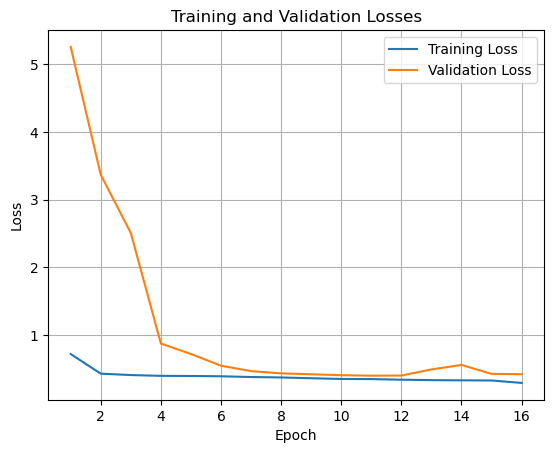

In [25]:
loss_plot(train_losses, val_losses)

### Model Testing

In [26]:
test_loss, test_true_labels, test_pred_labels = model_manager.test_model(test_loader)
print(f'The average test loss is {round(test_loss, 5)}')

The average test loss is 0.42255


In [27]:
print(classification_report(test_true_labels, test_pred_labels, target_names=med_annot_names, zero_division=0))

                          precision    recall  f1-score   support

                Erythema       0.71      0.84      0.77       438
                  Plaque       0.61      0.73      0.66       387
                  Papule       0.72      0.29      0.42       288
Brown(Hyperpigmentation)       0.83      0.12      0.21       209
                   Scale       0.00      0.00      0.00       147
                   Crust       0.34      0.47      0.39        94
                  Yellow       0.31      0.48      0.38        44
 White(Hypopigmentation)       0.00      0.00      0.00        58
                  Nodule       0.00      0.00      0.00        42
                 Erosion       0.00      0.00      0.00        41

               micro avg       0.62      0.47      0.54      1748
               macro avg       0.35      0.29      0.28      1748
            weighted avg       0.56      0.47      0.46      1748
             samples avg       0.49      0.42      0.43      1748



In [28]:
confusion_matrix = multilabel_confusion_matrix(test_true_labels, test_pred_labels)

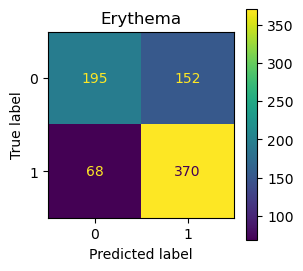

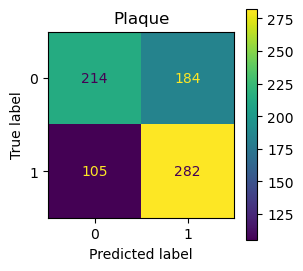

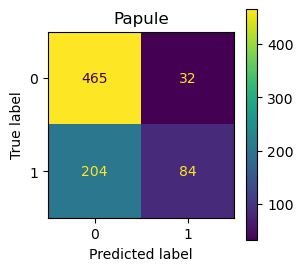

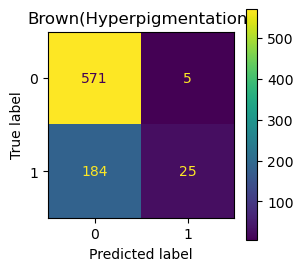

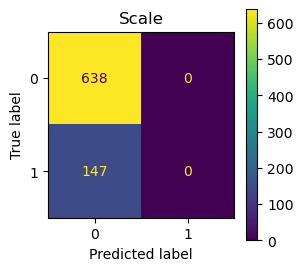

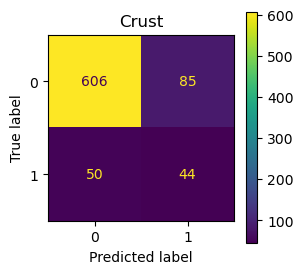

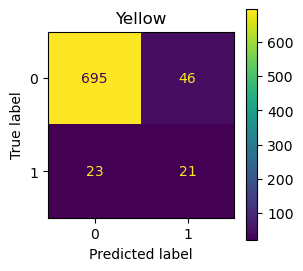

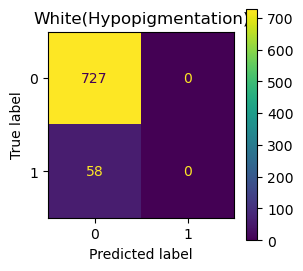

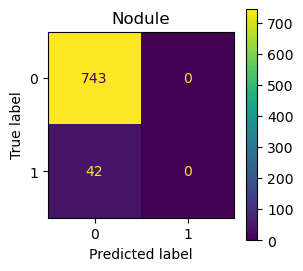

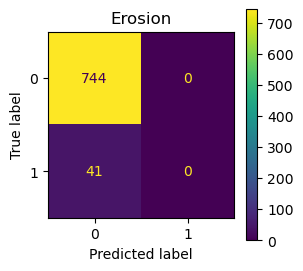

In [29]:
for i in range(len(med_annot_names)):
    fig, ax = plt.subplots(figsize=[3, 3])
    ConfusionMatrixDisplay(confusion_matrix[i]).plot(ax=ax)
    plt.title(med_annot_names[i])
    plt.show()